In [40]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [41]:
# import the raw data from csv files
alldata = pd.read_csv('Main_OList_Data.csv',sep=',')
df_RFM = pd.read_csv('RFM_OList_Data.csv',sep=',')
print(alldata.shape, df_RFM.shape)

(96770, 10) (96770, 11)


## 1. Clustering with K-means


In [42]:
alldata.columns
alldata= alldata.drop(['Unnamed: 0'], axis=1)

1.1 Variables selection

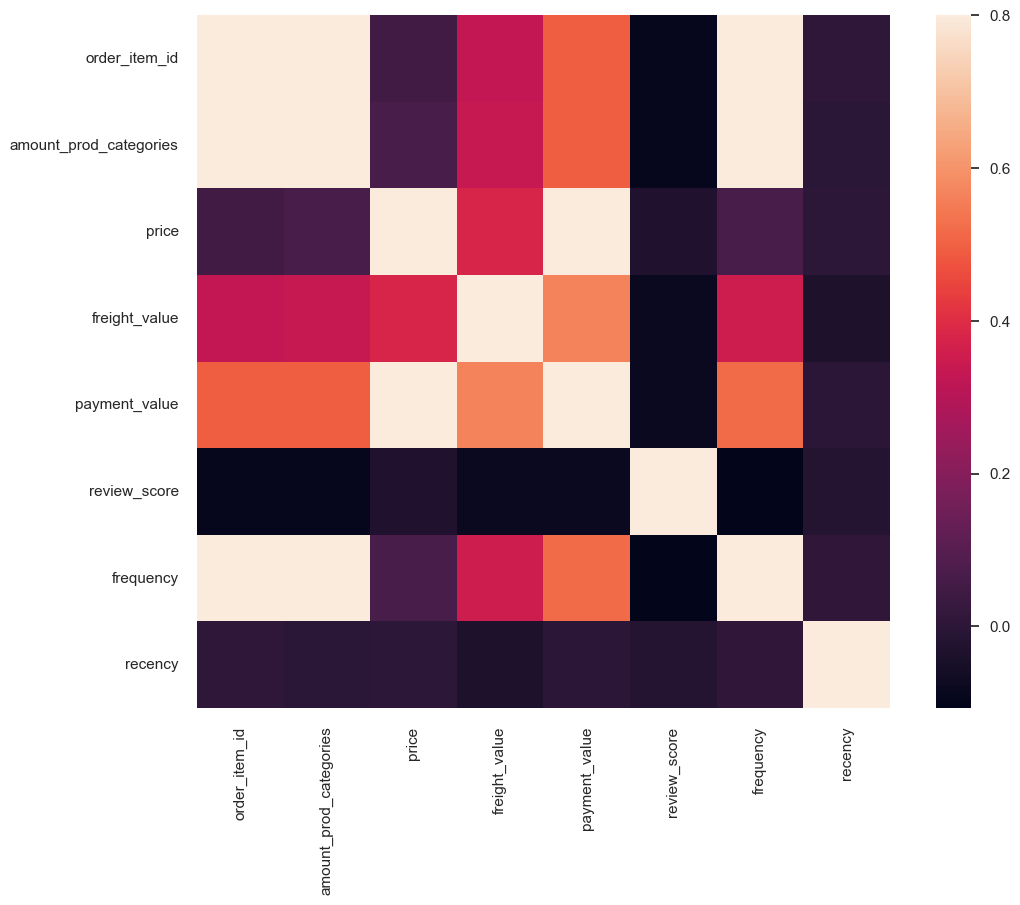

In [43]:
sns.set(style="white")
# 计算相似矩阵
corrmat = alldata.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmax=.8, square=True);

In [44]:
# 根据特征相似度筛选
#类别名称、交易价格、消费频率、评分、最近一次消费
grouping_variables = ['amount_prod_categories','payment_value', 'freight_value', 'review_score', 'recency'] 

In [45]:
df_reduced = alldata[grouping_variables]

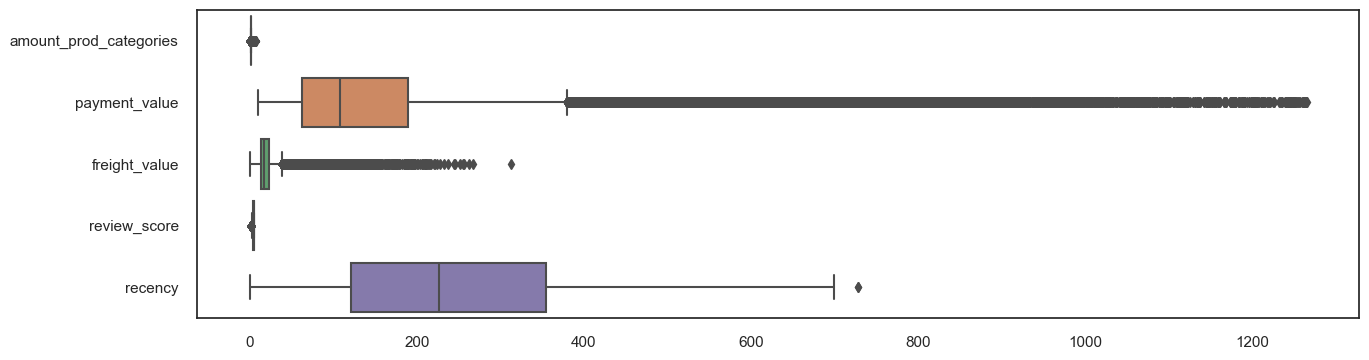

In [46]:
#箱型图显示变量分布
plt.figure(figsize = (15,4))
sns.boxplot(data = df_reduced, orient = "h")
plt.show()

### 1.1 Scaling

In [47]:
X = df_reduced.values

#scaler = preprocessing.StandardScaler()
#X_scaled = scaler.fit_transform(X) # variables normalized
#print(scaler.mean_)
#print(scaler.scale_)
X_scaled = scale(X)

print('X meanX',np.mean(X_scaled),',X standard deviation:',np.std(X_scaled), ".Ok, the features are scaled")

X meanX 8.399926523814763e-18 ,X standard deviation: 1.0 .Ok, the features are scaled


In [48]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X_scaled)
X_scaled = imputer.transform(X_scaled)

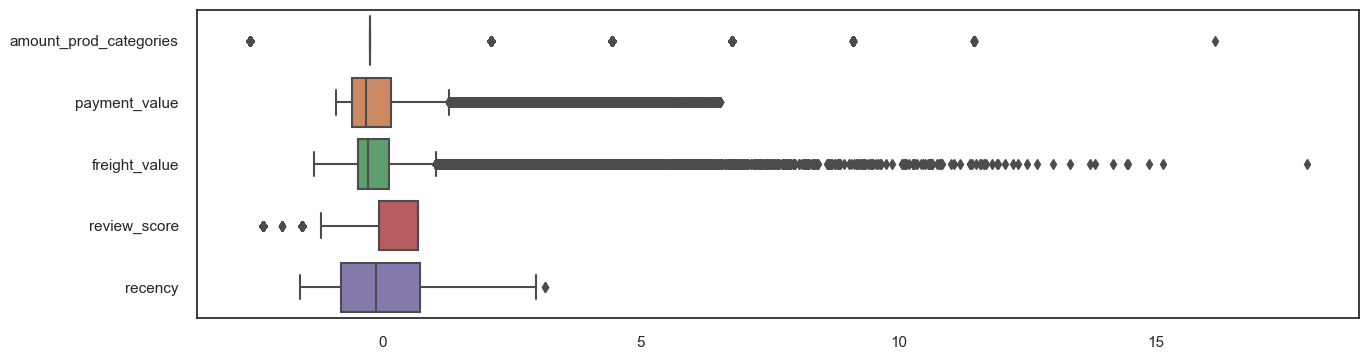

In [49]:
scaled_dataframe = pd.DataFrame( X_scaled, columns = df_reduced.columns )
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()

### 1.2 Create test and train set

In [50]:
train_size = int(len(X) * 0.98)
X_train, X_test = X[0:train_size], X[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(X_train)))
print('Testing Observations: %d' % (len(X_test)))

Observations: 96770
Training Observations: 94834
Testing Observations: 1936


### 1.3 K-means hyperparameters optimization 

In [51]:
# statistical gap : make a function that gives both gap and silhouette values
# https://uc-r.github.io/kmeans_clustering#gap
from sklearn.cluster import KMeans
wcss_all = []
allgaps = []

def optimalK(data, nrefs=3, maxClusters=10):
    """
    使用Tibshirani, Walther, Hastie的差距统计法计算KMeans的最佳K
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # dispersion results
        refDisps = np.zeros(nrefs)

        # 生成随机样本并进行kmeans，得到每个循环的结果分散度
        for i in range(nrefs):
            
            # 随机采样
            randomReference = np.random.random_sample(size=data.shape)

            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        km = KMeans(n_clusters = k, init="k-means++", random_state=10)
        km.fit(data)
        
        origDisp = km.inertia_

        # 计算gap
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap, 'WSS 1e8':round(origDisp/100000000,1)}, ignore_index=True)
        allgaps.append(gap)
        wcss_all.append(origDisp)
    print(resultsdf)        
    return(resultsdf)
   
    #print(wcss_all)

In [52]:
resultsdf = optimalK(X_train, nrefs=3, maxClusters=10)#.apply(lambda x: x.split(',')['clusterCount'])

   clusterCount        gap  WSS 1e8
0           1.0 -11.741790     49.7
1           2.0 -11.440534     31.2
2           3.0 -10.938308     16.9
3           4.0 -10.809647     13.4
4           5.0 -10.624681     10.2
5           6.0 -10.545864      8.8
6           7.0 -10.471778      7.7
7           8.0 -10.416438      6.8
8           9.0 -10.369215      6.1


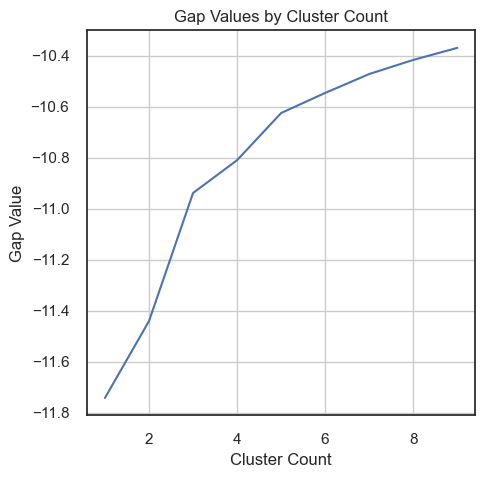

In [53]:
plt.figure(figsize=(5,5))
plt.plot(range(1,10), allgaps)
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

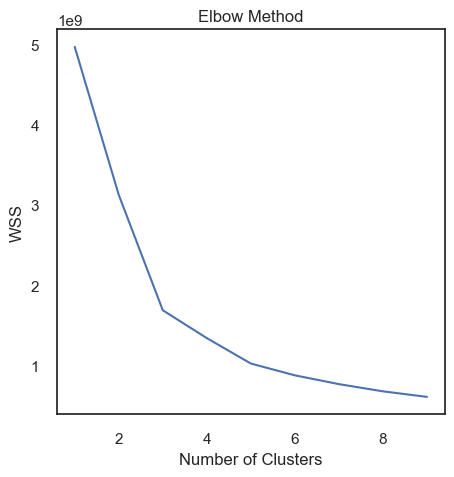

In [54]:
#使用Elbow方法确定分几类
plt.figure(figsize=(5,5))
plt.plot(range(1, 10), wcss_all)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

3或4个聚类应该是最佳值。

In [55]:
from yellowbrick.cluster.elbow import kelbow_visualizer

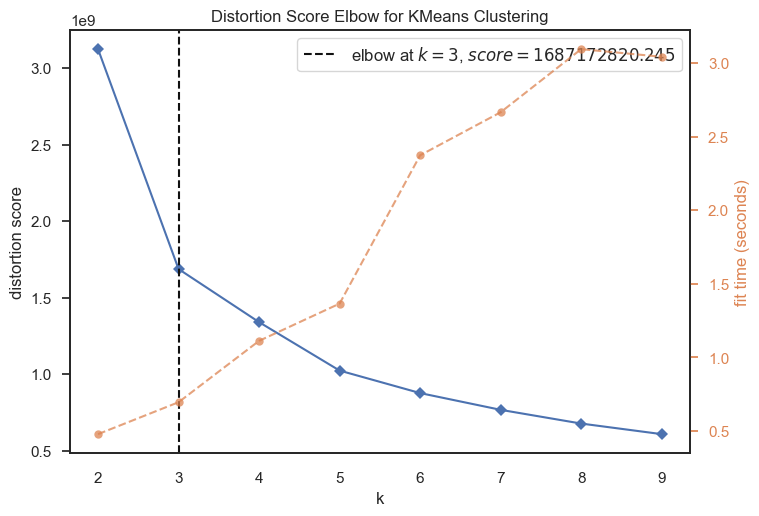

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=1), k=(2, 10))

In [56]:
kelbow_visualizer(KMeans(random_state=1), X_train, k=(2,10),metric='distortion')

1.5 Optimal number of cluster, based on Silhouette coefficients estimation

In [57]:
# k_means_silhouette = []
# from sklearn.metrics import silhouette_samples, silhouette_score
# for n_clusters in range(2,10):
    
#     # Initialize the clusterer
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(X_train)

#     # 轮廓系数
#     silhouette_avg = silhouette_score(X_train, cluster_labels)
#     k_means_silhouette.append(silhouette_avg)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", round(silhouette_avg,2) )

In [58]:
# plt.figure(figsize=(5,5))
# plt.plot(range(2, 10), k_means_silhouette)
# plt.title('Silhouette')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette_score') #within cluster sum of squares
# plt.show()

4 clusters has a high coeffiecient and is close to the WCSS elbow 

In [59]:
km = KMeans(n_clusters=3, init="random", random_state=10)
import time
time_start = time.time()
clusts_train = km.fit_predict(X_train)
print('K-Means done! Time elapsed: {} seconds'.format(time.time()-time_start))

K-Means done! Time elapsed: 0.6912174224853516 seconds


In [60]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score

 # 计算聚类效果的轮廓系数
score = silhouette_score(X_train, clusts_train)
print("轮廓系数为：", score)
# 计算Calinski-Harabasz Score
score_ch = calinski_harabasz_score(X_train, clusts_train)
print("Calinski-Harabasz Score为：", score_ch)
# 计算Davies-Bouldin Score
score_db = davies_bouldin_score(X_train, clusts_train)
print("Davies-Bouldin Score为：", score_db)



轮廓系数为： 0.4532233814844814
Calinski-Harabasz Score为： 92178.3882885564
Davies-Bouldin Score为： 0.7580992262770504


In [61]:
clusts_test = np.zeros(len(X_test)) # creation of an "artificial" cluster value for the test set
clusts_test = clusts_test + 42
clusts_test

array([42., 42., 42., ..., 42., 42., 42.])

创建一个可以转化为集群列的numpy数组

In [62]:
clust = np.concatenate((clusts_train, clusts_test), axis=None)
print(clusts_train.shape, clusts_test.shape ,clust.shape) # verify all is right shape

(94834,) (1936,) (96770,)


Creation of the dataframe that will be represented. Test data that have a special artificial cluster can now be joined back

In [63]:
df_train = pd.DataFrame.from_records(X_train)
df_test = pd.DataFrame.from_records(X_test)

In [64]:
df_clustered = pd.concat([df_train, df_test])#, ignore_index=True)
df_clustered.head()

,0,1,2,3,4
0,8.0,992.96,93.84,5.0,288.0
1,6.0,1252.08,76.74,1.0,170.0
2,6.0,426.60,47.22,5.0,9.0
3,6.0,774.18,84.66,5.0,692.0
4,6.0,1157.04,61.24,5.0,112.0


 ### 1.4.1 KM-clusters  --  PCA

In [65]:
from sklearn.decomposition import PCA
pca_feat = PCA(n_components=2)
time_start = time.time()
X_PCA = pca_feat.fit_transform(df_clustered)
print(pca_feat.explained_variance_ratio_)
# Plot the explained variances
features = range(pca_feat.n_components_)
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

[0.54576988 0.45078097]
PCA done! Time elapsed: 0.08047628402709961 seconds


In [66]:
df_PCA = pd.DataFrame.from_records(X_PCA)
clust_series = pd.Series(clust)
clust_series.head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
dtype: float64

In [67]:
df_PCA = df_PCA.assign(cluster = clust_series)

df_PCA.columns

Index([0, 1, 'cluster'], dtype='object')

In [68]:
df_PCA = df_PCA.rename(columns={0: 'PCA_1', 1: 'PCA_2'})
df_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 42: "Test values"}, inplace=True)
df_PCA.head()

,PCA_1,PCA_2,cluster
0,832.699107,51.037656,Cluster 3
1,1091.605743,-64.378500,Cluster 3
2,267.318904,-233.303386,Cluster 3
3,609.901255,452.918387,Cluster 3
4,996.413936,-123.249609,Cluster 3


In [69]:
df_PCA = df_PCA.dropna()
print(df_PCA.columns, df_PCA.shape)

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


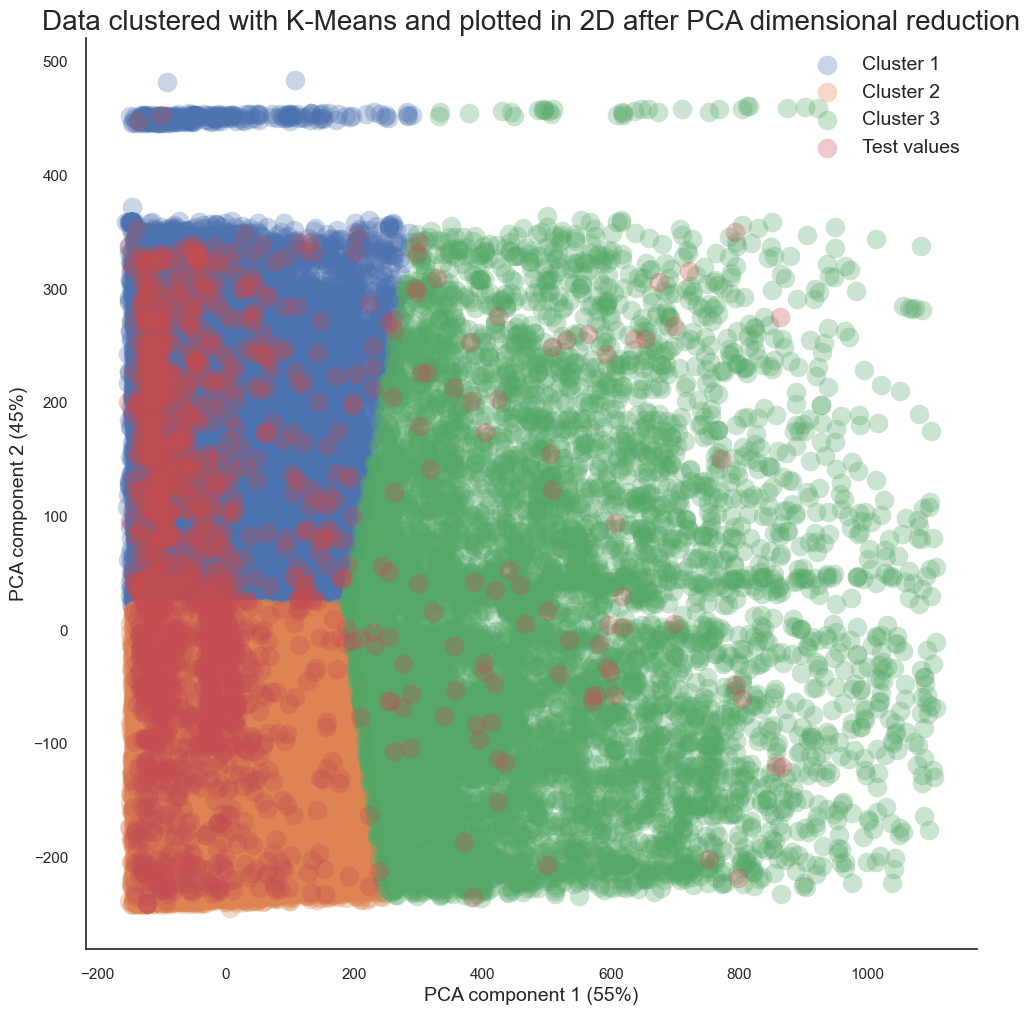

In [70]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3','Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = df_PCA, fit_reg = False, legend = False, height = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.xlabel('PCA component 1 (55%)', fontsize = 14)
plt.ylabel('PCA component 2 (45%)', fontsize = 14)
plt.title('Data clustered with K-Means and plotted in 2D after PCA dimensional reduction', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

### 1.4.2 KM-clusters  --  T-SNE

In [71]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=31, random_state=0 )

In [72]:
# create a numpy matrix by concatenation of train and test datasets
X_concat = df_clustered.values#np.concatenate((X_train, X_test), axis=None)

In [73]:

time_start = time.time()

X_TSNE = tsne.fit_transform(X_concat)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

d:\softwares\Python\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\softwares\Python\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 325.3638708591461 seconds


In [74]:
df_TSNE = pd.DataFrame.from_records(X_TSNE)
print(df_TSNE.shape)
df_TSNE.head()

(96770, 2)


,0,1
0,-9.075597,-34.674942
1,-12.810887,-29.519806
2,-14.570498,-33.102829
3,3.941376,-33.994030
4,-13.545540,-29.955259


In [75]:
clust_series = pd.Series(clust)

In [76]:
df_TSNE = df_TSNE.assign(cluster = clust_series)

print(df_TSNE.columns, df_TSNE.shape)
df_TSNE = df_TSNE.rename(columns={0: 'TSNE_1', 1: 'TSNE_2'})
df_TSNE["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 42: "Test values"}, inplace=True)
df_TSNE.head()

Index([0, 1, 'cluster'], dtype='object') (96770, 3)


,TSNE_1,TSNE_2,cluster
0,-9.075597,-34.674942,Cluster 3
1,-12.810887,-29.519806,Cluster 3
2,-14.570498,-33.102829,Cluster 3
3,3.941376,-33.994030,Cluster 3
4,-13.545540,-29.955259,Cluster 3


In [77]:
df_TSNE["cluster"].value_counts()

Cluster 2      49781
Cluster 1      37004
Cluster 3       8049
Test values     1936
Name: cluster, dtype: int64

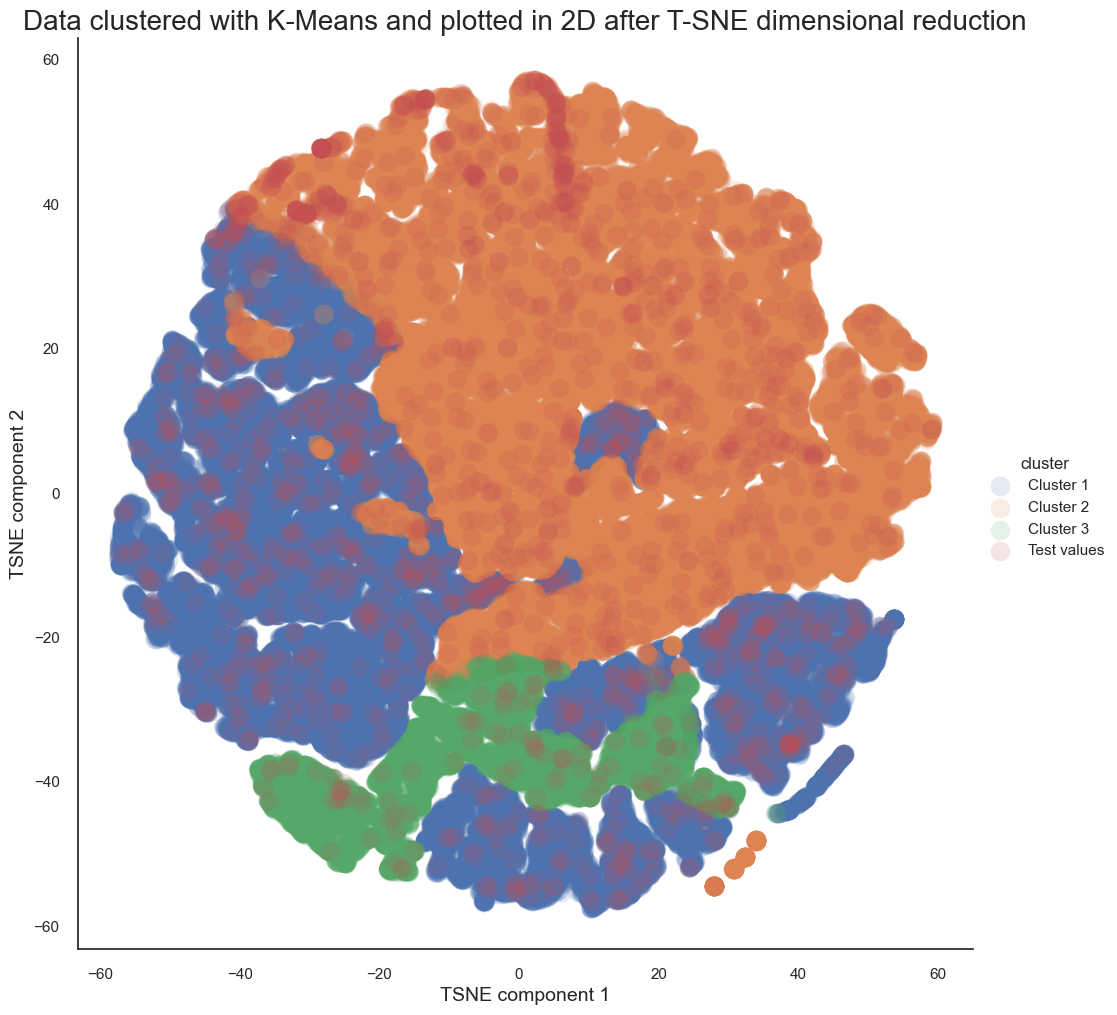

In [78]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3','Test values']
sns.lmplot(x = 'TSNE_1', y = 'TSNE_2', data = df_TSNE, fit_reg = False, legend = True, height = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.15} )
plt.xlabel('TSNE component 1', fontsize = 14)
plt.ylabel('TSNE component 2', fontsize = 14)
plt.title('Data clustered with K-Means and plotted in 2D after T-SNE dimensional reduction', fontsize = 20)
plt.show()

### 1.5 Boxplot for each feature

In [79]:
df_clustered_labeled = df_clustered.assign(cluster = clust_series)
df_clustered_labeled.head()


,0,1,2,3,4,cluster
0,8.0,992.96,93.84,5.0,288.0,2.0
1,6.0,1252.08,76.74,1.0,170.0,2.0
2,6.0,426.60,47.22,5.0,9.0,2.0
3,6.0,774.18,84.66,5.0,692.0,2.0
4,6.0,1157.04,61.24,5.0,112.0,2.0


In [80]:
df_clustered_labeled.cluster.unique()

array([2., 1., 0.])

In [81]:
columnsvector = df_reduced.columns
print(columnsvector)
df_train_labeled = df_train
df_train_labeled.columns = columnsvector



Index(['amount_prod_categories', 'payment_value', 'freight_value',
       'review_score', 'recency'],
      dtype='object')


In [82]:
df_train_labeled = df_train_labeled.assign(cluster = clusts_train)
df_train_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3"}, inplace=True)
df_train_labeled.head()

,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 3
1,6.0,1252.08,76.74,1.0,170.0,Cluster 3
2,6.0,426.60,47.22,5.0,9.0,Cluster 3
3,6.0,774.18,84.66,5.0,692.0,Cluster 3
4,6.0,1157.04,61.24,5.0,112.0,Cluster 3


In [83]:
x1 = df_train_labeled["cluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order = ["Cluster 1", "Cluster 2", "Cluster 3"]


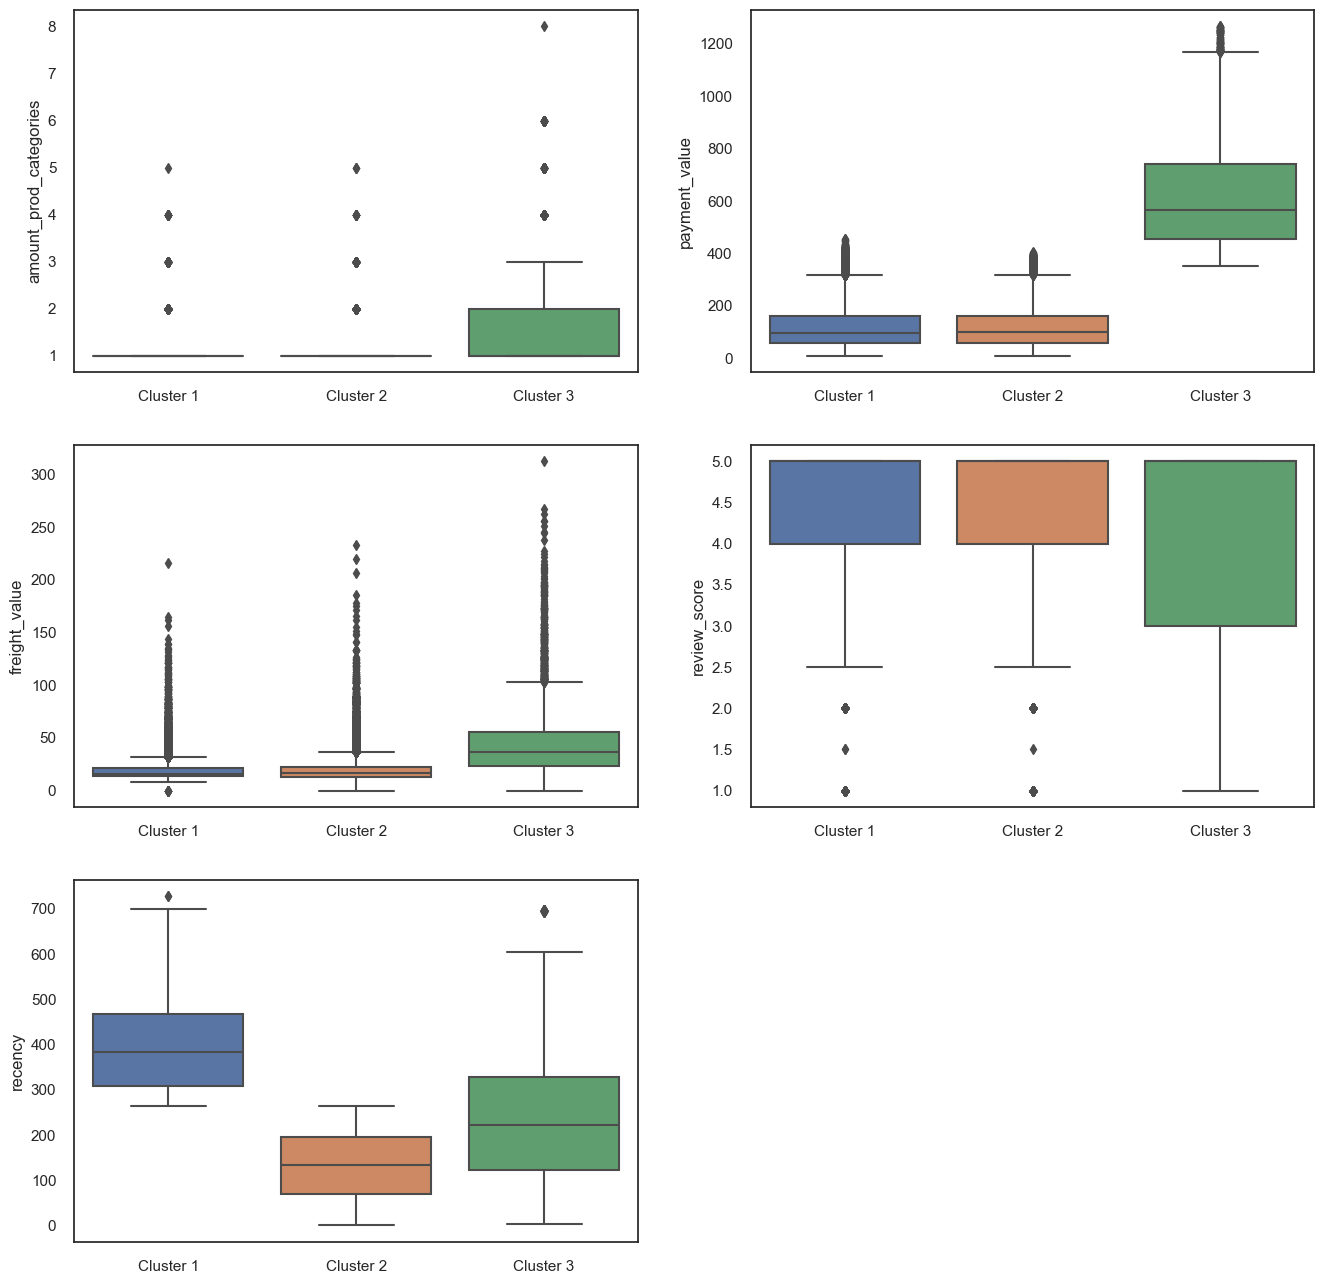

In [84]:
plt.figure(figsize=(16,16))



#sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x=x1, y=y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x=x1, y=y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x=x1, y=y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x=x1, y=y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x=x1, y=y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()

### 1.6  验证K-MEANS稳定性

In [85]:
km = KMeans(n_clusters=3, init="random", random_state=10)
import time
time_start = time.time()
clusts_test1 = km.fit_predict(X_test)
print('K-Means done! Time elapsed: {} seconds'.format(time.time()-time_start))

K-Means done! Time elapsed: 0.11166262626647949 seconds


In [86]:
df_test_labeled = df_test.assign(cluster = clusts_test1)
df_test_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3"}, inplace=True)
df_test_labeled.head()

,0,1,2,3,4,cluster
0,1.0,113.15,13.25,3.0,285.0,Cluster 3
1,1.0,315.54,16.54,5.0,11.0,Cluster 3
2,1.0,194.81,19.51,4.0,519.0,Cluster 1
3,1.0,56.78,7.78,5.0,264.0,Cluster 3
4,1.0,131.51,21.61,4.0,209.0,Cluster 3


In [87]:
print (len(df_train_labeled["cluster"]))
(df_train_labeled["cluster"].value_counts()/len(df_train_labeled["cluster"]))*100

94834


Cluster 2    52.492777
Cluster 1    39.019761
Cluster 3     8.487462
Name: cluster, dtype: float64

In [88]:
print (len(df_test_labeled["cluster"]))
(df_test_labeled["cluster"].value_counts()/len(df_test_labeled["cluster"]))*100

1936


Cluster 3    61.518595
Cluster 1    33.419421
Cluster 2     5.061983
Name: cluster, dtype: float64

## 3 Clustering with DB-Scan algorythm

### 3.1 testing the optimal DB-Scan parameters

In [89]:
from sklearn import datasets # To import the sample dataset
from sklearn.preprocessing import StandardScaler # To transform the dataset
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from sklearn.metrics import silhouette_score


In [90]:
#eps_to_test = [0.01, 0.02,1]
#min_samples_to_test = [3,10, 20, 75]
eps_to_test = [40,45,50]
min_samples_to_test = [10,15,20]
print("EPS VALUES:", eps_to_test)
print("MIN_SAMPLES:", min_samples_to_test)

EPS VALUES: [40, 45, 50]
MIN_SAMPLES: [10, 15, 20]


In [91]:
# from sklearn.neighbors import NearestNeighbors

# X=X_train
# k=3
# neigh = NearestNeighbors(n_neighbors=k)
# distances, _ = neigh.fit(X).kneighbors(X)
# k_distances = np.sort(distances[:, -1])

# # 绘制K-距离图
# plt.plot(np.arange(1, len(X)+1), k_distances)
# plt.xlabel('样本索引')
# plt.ylabel(f'{k}-距离')
# plt.title(f'K-距离图（K={k}）')
# plt.show()

In [92]:
test_pair=[]

def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)

    # 平均噪声点距离指标
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # 发现的cluster数量指标
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))

    if number_of_clusters>0:
        test_pair.append([eps,min_samples])

    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [93]:
# Average distance from closest K
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Number of cluster metrics dataframe
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [94]:
# iter_ = 0

# print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
# print("-"*65)

# for eps in eps_to_test:
#     for min_samples in min_samples_to_test:
        
#         iter_ += 1
        
#         # Metrics computation
#         noise_metric, cluster_metric = get_metrics(eps, min_samples, X_train, iter_)

#         # Results in the respective dataframe
#         results_noise.loc[eps, min_samples] = noise_metric
#         results_clusters.loc[eps, min_samples] = cluster_metric

In [95]:
# for i in test_pair:
#     _dbscan_model = DBSCAN( eps = i[0], min_samples = i[1])
#     _dbscan_labels = _dbscan_model.fit_predict(X_train)
#     print(i[0],i[1])
#     # 轮廓系数
#     _descan_silhouette_avg = silhouette_score(X_train, _dbscan_labels)
#     print(_descan_silhouette_avg)


确定超参数 eps=45，min_samples_to_test=20

### 3.2 Grouping using optimized DB-Scan: select a combination with few clusters, similar to K-means

In [96]:
eps = 45
min_samples_to_test = 20
time_start = time.time()
dbscan_model = DBSCAN( eps = eps, min_samples = min_samples_to_test)

# Fitting
DBclusts_train = dbscan_model.fit(X_train)
print('DBScan done! Time elapsed: {} seconds'.format(time.time()-time_start))


DBScan done! Time elapsed: 16.71378445625305 seconds


In [97]:
#Metrics calculation

noise_metric, cluster_metric = get_metrics(eps, min_samples_to_test, X_train, 1)


  1 | Tested with eps =  45 and min_samples =  20 | 40.104    3


In [98]:
DBclust = np.concatenate((DBclusts_train.labels_, clusts_test), axis=None)
print(clusts_test.shape ,DBclust.shape) # verify all is right shape
DBclust_series = pd.Series(DBclust) # transform to Pandas dataframe

(1936,) (96770,)


In [99]:
dbtrainvector = DBclusts_train.labels_
# 轮廓系数
descan_silhouette_avg = silhouette_score(X_train, dbtrainvector)
print(descan_silhouette_avg)

0.3862133131923894


In [100]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score

 # 计算聚类效果的轮廓系数
score = silhouette_score(X_train, dbtrainvector)
print("轮廓系数为：", score)
# 计算Calinski-Harabasz Score
score_ch = calinski_harabasz_score(X_train, dbtrainvector)
print("Calinski-Harabasz Score为：", score_ch)
# 计算Davies-Bouldin Score
score_db = davies_bouldin_score(X_train, dbtrainvector)
print("Davies-Bouldin Score为：", score_db)



轮廓系数为： 0.3862133131923894
Calinski-Harabasz Score为： 2606.7395818336004
Davies-Bouldin Score为： 0.9442218324929353


### 3.3 Representation in 2D using PCA

In [101]:
dfDB_PCA = df_PCA.assign(cluster = DBclust_series)

print(dfDB_PCA.columns, dfDB_PCA.shape)

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


In [102]:
dfDB_PCA['cluster'].value_counts()

 0.0     94052
 42.0     1936
-1.0       475
 2.0       260
 1.0        47
Name: cluster, dtype: int64

In [103]:
dfDB_PCA = dfDB_PCA.dropna()
print(dfDB_PCA.columns, dfDB_PCA.shape)
dfDB_PCA['cluster'].unique()

Index(['PCA_1', 'PCA_2', 'cluster'], dtype='object') (96770, 3)


array([ 0., -1.,  1.,  2., 42.])

In [104]:
dfDB_PCA["cluster"].replace({ -1: "Cluster 0"}, inplace=True)


In [105]:
dfDB_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5", 42: "Test values"}, inplace=True)

dfDB_PCA.head()

,PCA_1,PCA_2,cluster
0,832.699107,51.037656,Cluster 1
1,1091.605743,-64.378500,Cluster 0
2,267.318904,-233.303386,Cluster 1
3,609.901255,452.918387,Cluster 0
4,996.413936,-123.249609,Cluster 0


In [106]:
dfDB_PCA['cluster'].value_counts()

Cluster 1      94052
Test values     1936
Cluster 0        475
Cluster 3        260
Cluster 2         47
Name: cluster, dtype: int64

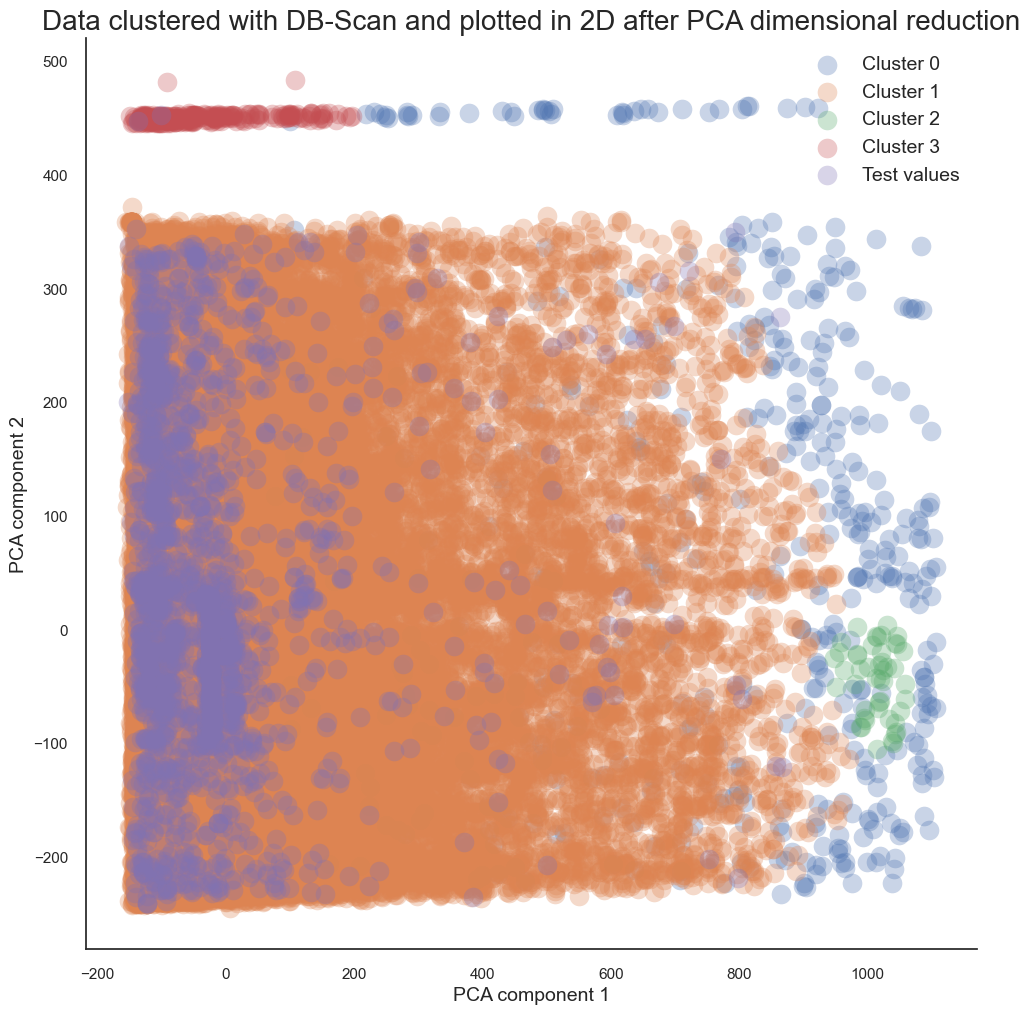

In [107]:
db_orderhue= ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3',  'Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = dfDB_PCA, fit_reg = False, legend = False, height = 10, hue = "cluster", hue_order= db_orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.title('Data clustered with DB-Scan and plotted in 2D after PCA dimensional reduction' , fontsize = 20)
plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [108]:
df_train_labeled = df_train_labeled.assign(dbcluster = dbtrainvector)
df_train_labeled["dbcluster"].replace({-1: "Cluster 1", 0: "Cluster 2", 1: "Cluster 3", 2: "Cluster 4"}, inplace=True)
print(df_train_labeled["dbcluster"].unique())
df_train_labeled.head()

['Cluster 2' 'Cluster 1' 'Cluster 3' 'Cluster 4']


,amount_prod_categories,payment_value,freight_value,review_score,recency,cluster,dbcluster
0,8.0,992.96,93.84,5.0,288.0,Cluster 3,Cluster 2
1,6.0,1252.08,76.74,1.0,170.0,Cluster 3,Cluster 1
2,6.0,426.60,47.22,5.0,9.0,Cluster 3,Cluster 2
3,6.0,774.18,84.66,5.0,692.0,Cluster 3,Cluster 1
4,6.0,1157.04,61.24,5.0,112.0,Cluster 3,Cluster 1


### 3.4 Boxplot for each feature

In [109]:
x2 = df_train_labeled["dbcluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order1 = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]



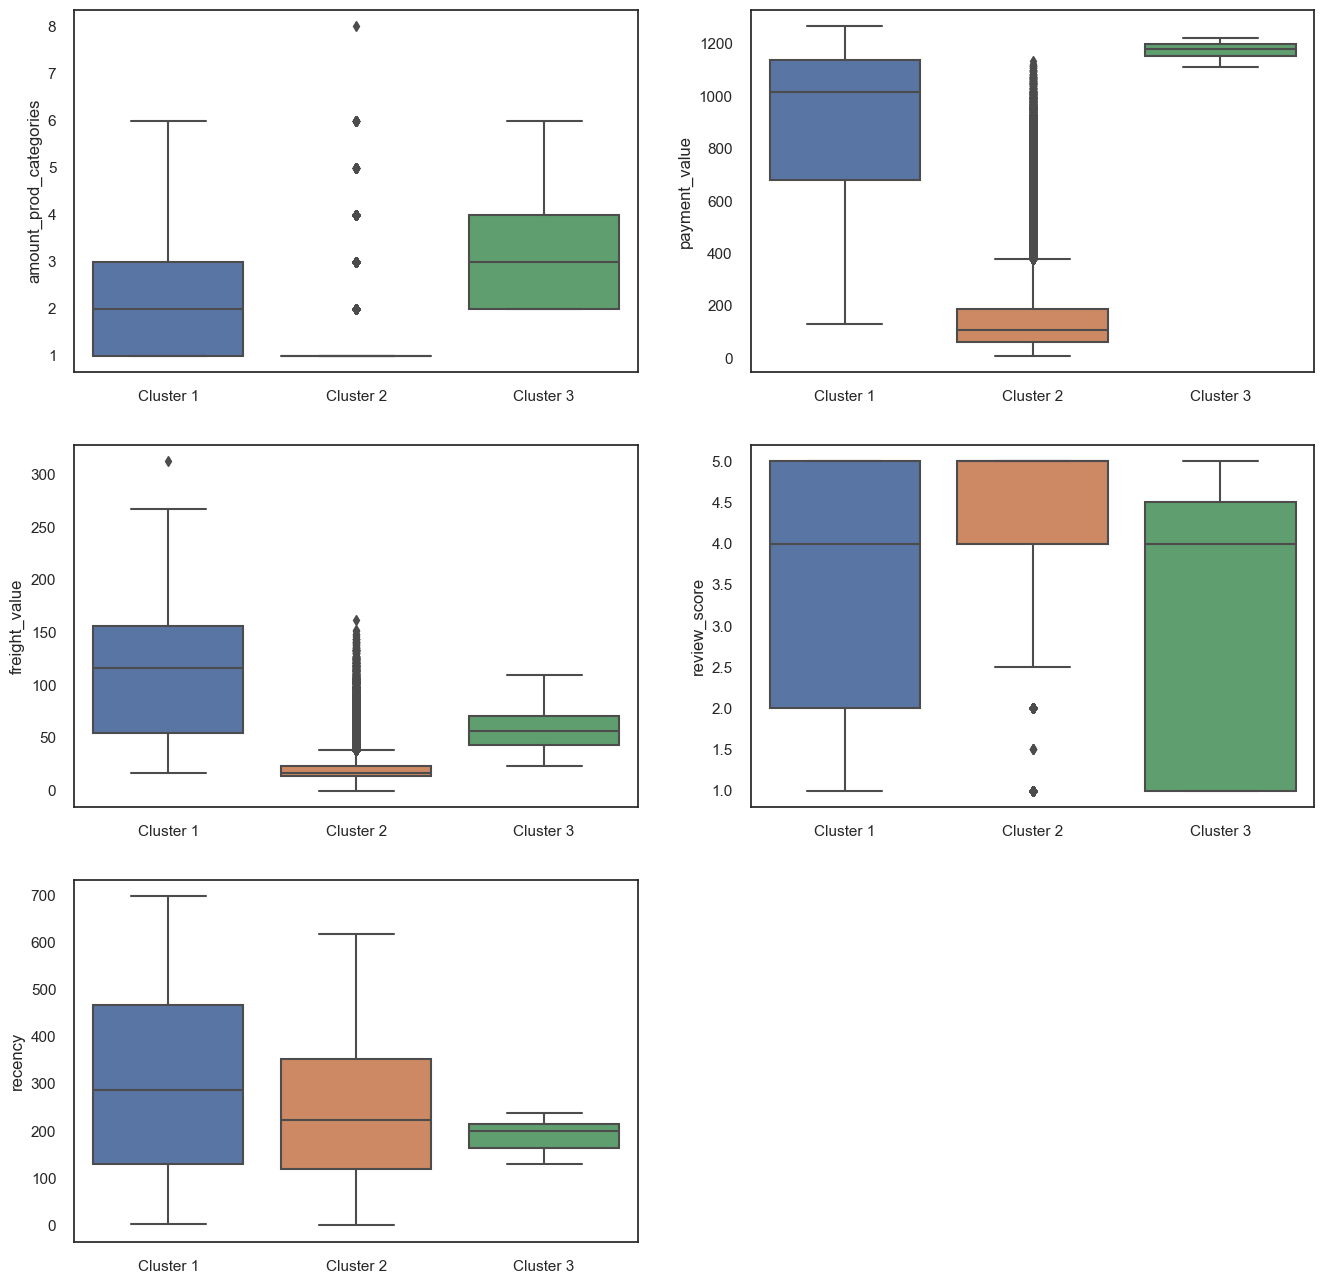

In [110]:
plt.figure(figsize=(16,16))





plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x=x2, y=y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x=x2,  y=y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x=x2,  y=y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x=x2,  y=y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x=x2,  y=y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()